In [1]:
import sys
print(sys.executable)


/Users/parisakhosravi/miniconda3/bin/python


In [2]:
!pip uninstall -y sdv sdmetrics
!pip install sdv==1.20.0 sdmetrics==0.20.1



Found existing installation: sdv 1.20.0
Uninstalling sdv-1.20.0:
  Successfully uninstalled sdv-1.20.0
Found existing installation: sdmetrics 0.20.1
Uninstalling sdmetrics-0.20.1:
  Successfully uninstalled sdmetrics-0.20.1
  Using cached sdv-1.20.0-py3-none-any.whl.metadata (14 kB)
  Using cached sdmetrics-0.20.1-py3-none-any.whl.metadata (9.4 kB)
Using cached sdv-1.20.0-py3-none-any.whl (157 kB)
Using cached sdmetrics-0.20.1-py3-none-any.whl (193 kB)


In [12]:
!which python
!python -m pip show sdv
!python -m pip show sdmetrics


/Users/parisakhosravi/miniconda3/bin/python
Name: sdv
Version: 1.20.0
Summary: Generate synthetic data for single table, multi table and sequential data
Home-page: 
Author: 
Author-email: "DataCebo, Inc." <info@sdv.dev>
License: BSL-1.1
Location: /Users/parisakhosravi/miniconda3/lib/python3.13/site-packages
Requires: boto3, botocore, cloudpickle, copulas, ctgan, deepecho, graphviz, numpy, pandas, platformdirs, pyyaml, rdt, sdmetrics, tqdm
Required-by: 
Name: sdmetrics
Version: 0.20.1
Summary: Metrics for Synthetic Data Generation Projects
Home-page: 
Author: 
Author-email: MIT Data To AI Lab <dailabmit@gmail.com>
License: MIT license
Location: /Users/parisakhosravi/miniconda3/lib/python3.13/site-packages
Requires: copulas, numpy, pandas, plotly, scikit-learn, scipy, tqdm
Required-by: sdv


In [3]:
import sys
print(sys.executable)


/Users/parisakhosravi/miniconda3/bin/python


In [4]:
import pandas as pd
import numpy as np
from sdv.metadata import SingleTableMetadata

In [5]:
metadata = SingleTableMetadata()
data = pd.read_csv('Data/Real_Datasets/wine_processed_dedu.csv')
metadata.detect_from_dataframe(data)

In [6]:
print(metadata)

{
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        "fixed acidity": {
            "sdtype": "numerical"
        },
        "volatile acidity": {
            "sdtype": "numerical"
        },
        "citric acid": {
            "sdtype": "numerical"
        },
        "residual sugar": {
            "sdtype": "numerical"
        },
        "chlorides": {
            "sdtype": "numerical"
        },
        "free sulfur dioxide": {
            "sdtype": "numerical"
        },
        "total sulfur dioxide": {
            "sdtype": "numerical"
        },
        "density": {
            "sdtype": "numerical"
        },
        "pH": {
            "sdtype": "numerical"
        },
        "sulphates": {
            "sdtype": "numerical"
        },
        "alcohol": {
            "sdtype": "numerical"
        },
        "quality": {
            "sdtype": "numerical"
        },
        "type": {
            "sdtype": "categorical"
        }
    }
}


In [7]:
import os
import time
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import NearestNeighbors
from sdv.single_table import TVAESynthesizer

def run_tvae_experiment(
    run_id: int,
    metadata,                       
    epochs: int = 300,
    batch_size: int = 500,
    enforce_min_max_values: bool = True,
    enforce_rounding: bool = False,
    verbose: bool = True
):
    print(f"\n Running TVAE experiment {run_id} — epochs={epochs}, batch_size={batch_size}")

    
    real_path = "Data/Real_Datasets/wine_processed_dedu.csv"
    fake_dir  = "Data/Synthetic_Datasets/TVAE"
    log_path  = "Data/Synthetic_Datasets/experiment_log_tvae.csv"

    os.makedirs(fake_dir, exist_ok=True)
    fake_path = os.path.join(fake_dir, f"tvae_run_{run_id}.csv")

    # === Load real data ===
    real_df = pd.read_csv(real_path)

    # === Instantiate TVAE ===
    synthesizer = TVAESynthesizer(
        metadata=metadata,
        enforce_min_max_values=enforce_min_max_values,
        enforce_rounding=enforce_rounding,
        epochs=epochs,
        batch_size=batch_size,
        verbose=verbose
    )


    # === Train ===
    start_train = time.time()
    synthesizer.fit(real_df)
    train_time = time.time() - start_train

    # === Generate (match real row count) ===
    start_gen = time.time()
    synth_data = synthesizer.sample(num_rows=len(real_df))
    gen_time = time.time() - start_gen

    # Save fake dataset (changes with run_id)
    synth_data.to_csv(fake_path, index=False)

    # === Evaluation (numeric-only correlation + memorization checks) ===
    real_data = real_df.drop(columns=['type'], errors='ignore')
    synth_data_numeric = synth_data.drop(columns=['type'], errors='ignore')

    # Correlation metrics
    pearson_mae = mean_absolute_error(
        real_data.corr().values.flatten(),
        synth_data_numeric.corr().values.flatten()
    )
    spearman_mae = mean_absolute_error(
        real_data.corr(method='spearman').values.flatten(),
        synth_data_numeric.corr(method='spearman').values.flatten()
    )

    # Memorization check
    numeric_cols = real_data.select_dtypes(include=[np.number]).columns.tolist()
    Xr = real_data[numeric_cols].to_numpy(dtype=float)
    Xf = synth_data_numeric[numeric_cols].to_numpy(dtype=float)

    nn_rr = NearestNeighbors(n_neighbors=2, metric="euclidean").fit(Xr)
    dist_rr, _ = nn_rr.kneighbors(Xr, return_distance=True)
    rr_other = dist_rr[:, 1]
    RR_median = float(np.median(rr_other))
    RR_p05    = float(np.percentile(rr_other, 5))
    RR_p01    = float(np.percentile(rr_other, 1))

    nn_fr = NearestNeighbors(n_neighbors=2, metric="euclidean").fit(Xr)
    dist_fr, _ = nn_fr.kneighbors(Xf, return_distance=True)
    fr1, fr2 = dist_fr[:, 0], dist_fr[:, 1]
    FR_median = float(np.median(fr1))
    FR_p05    = float(np.percentile(fr1, 5))
    pct_FR_below_RR1pct = float(np.mean(fr1 < RR_p01) * 100.0)

    eps = 0.01 * RR_median if RR_median > 0 else 0.0
    near_dup_rate = float(np.mean(fr1 < eps) * 100.0)

    # === Logging (append or create) ===
    log_row = {
        'run_id': run_id,
        'epochs': epochs,
        'batch_size': batch_size,
        'pearson_mae': pearson_mae,
        'spearman_mae': spearman_mae,
        'RR_median': RR_median,
        'RR_p05': RR_p05,
        'RR_p01': RR_p01,
        'FR_median': FR_median,
        'FR_p05': FR_p05,
        'pct_FR_below_RR1pct': pct_FR_below_RR1pct,
        'near_dup_rate': near_dup_rate,
        'eps_used': eps,
        'train_time_sec': round(train_time, 2),
        'gen_time_sec': round(gen_time, 2)
    }

    log_df = pd.DataFrame([log_row])
    if os.path.exists(log_path):
        log_df.to_csv(log_path, mode='a', header=False, index=False)
    else:
        log_df.to_csv(log_path, index=False)

    print("\n Results:")
    for k, v in log_row.items():
        print(f"{k}: {v}")

    return real_data, synth_data_numeric


In [15]:
_ = run_tvae_experiment(
    run_id=14,
    metadata=metadata,
    epochs=2400,
    batch_size=64
)



 Running TVAE experiment 14 — epochs=2400, batch_size=64


/Users/parisakhosravi/miniconda3/lib/python3.13/site-packages/sdv/single_table/base.py:126: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
Loss: -16.764: 100%|████████████████████████| 2400/2400 [07:10<00:00,  5.57it/s]



 Results:
run_id: 14
epochs: 2400
batch_size: 64
pearson_mae: 0.04349117144505643
spearman_mae: 0.04565540982831082
RR_median: 0.9774631429422356
RR_p05: 0.23142579653857615
RR_p01: 0.07714061450996036
FR_median: 1.13863224798434
FR_p05: 0.7243563950291844
pct_FR_below_RR1pct: 0.0
near_dup_rate: 0.0
eps_used: 0.009774631429422356
train_time_sec: 435.48
gen_time_sec: 0.04


In [4]:
from sdv.single_table import TVAESynthesizer

In [65]:
synthesizer = TVAESynthesizer(metadata,
                              enforce_min_max_values=True,
                              enforce_rounding=False,
                              epochs=180,
                              verbose= True)

/Users/parisakhosravi/Library/Python/3.9/lib/python/site-packages/sdv/single_table/base.py:144: FutureWarning:

The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.



In [66]:
synthesizer.fit(data)

Loss: -1.831: 100%|███████████████████████████| 180/180 [00:13<00:00, 13.33it/s]


In [67]:
synthetic_data = synthesizer.sample(num_rows=6497)

In [68]:
# Match dtypes to the original dataset
for col in data.columns:
    synthetic_data[col] = synthetic_data[col].astype(data[col].dtype)


In [69]:
synthetic_data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,-0.082106,-0.020054,-0.225157,-0.018778,-0.115856,-0.049903,0.005614,-0.027019,-0.101110,-0.288752,0.051253,-0.042945
std,0.812806,0.951753,0.919306,1.039292,0.611298,1.122884,1.004346,0.882299,1.122907,0.795946,0.969591,0.749435
min,-2.062305,-1.728369,-2.192833,-1.614592,-1.363232,-3.263001,-3.765669,-2.370721,-3.024501,-2.091935,-1.803175,-2.089533
25%,-0.589960,-0.732421,-0.533153,-0.933975,-0.529727,-0.796880,-0.337123,-0.750861,-0.930928,-0.806564,-0.836809,-0.936990
50%,-0.259713,-0.319086,-0.221618,-0.536293,-0.270990,0.317732,0.357840,0.063081,-0.219837,-0.435937,0.029667,0.207128
75%,0.191047,0.654329,0.074948,0.932526,0.262267,0.819177,0.692566,0.686823,0.628434,-0.011193,0.766963,0.208144
max,5.013450,2.977484,3.933391,2.239139,12.142122,1.748706,1.503364,2.245291,3.599707,5.397500,3.136523,2.502458


In [70]:
synthetic_data.to_csv("Data/Synthetic_Datasets/TVAE/synthetic_tvae_data.csv", index=False)


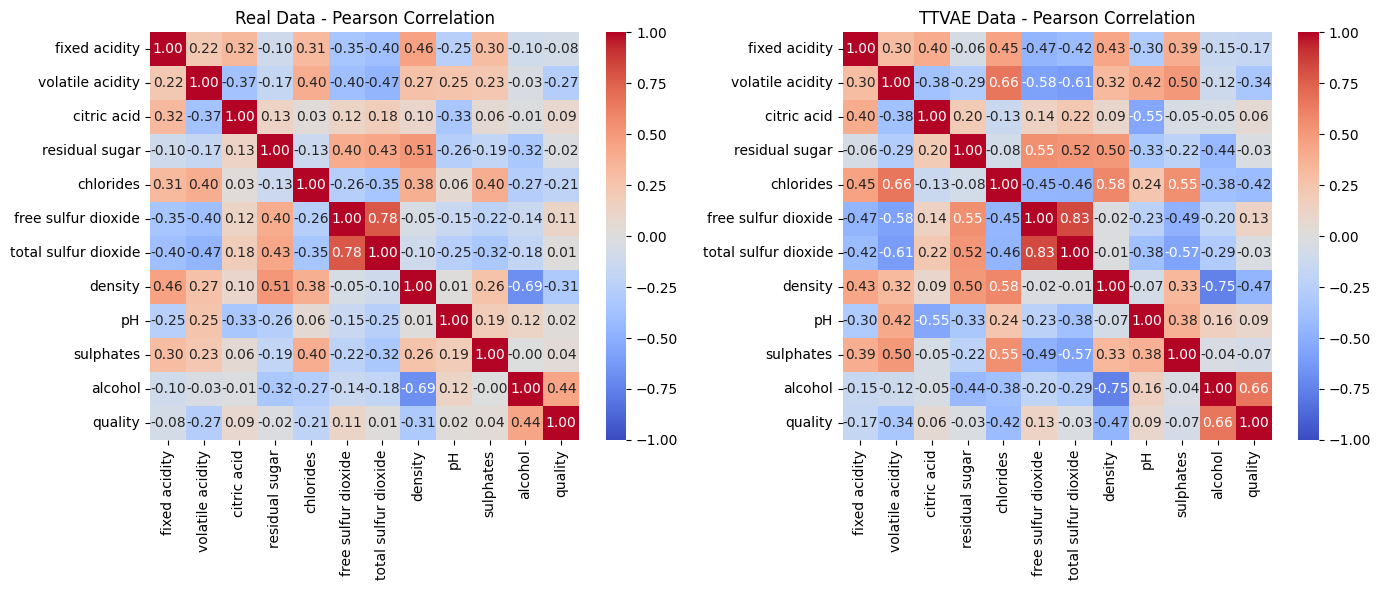

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

real_num = data.select_dtypes(include='number')
tvae_num = synthetic_data.select_dtypes(include='number')

real_pearson = real_num.corr(method='pearson')
tvae_pearson = tvae_num.corr(method='pearson')

plt.figure(figsize=(14, 6))

# Original data
plt.subplot(1, 2, 1)
sns.heatmap(real_pearson, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Real Data - Pearson Correlation')

# Synthesized data
plt.subplot(1, 2, 2)
sns.heatmap(tvae_pearson, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('TTVAE Data - Pearson Correlation')

plt.tight_layout()
plt.show()

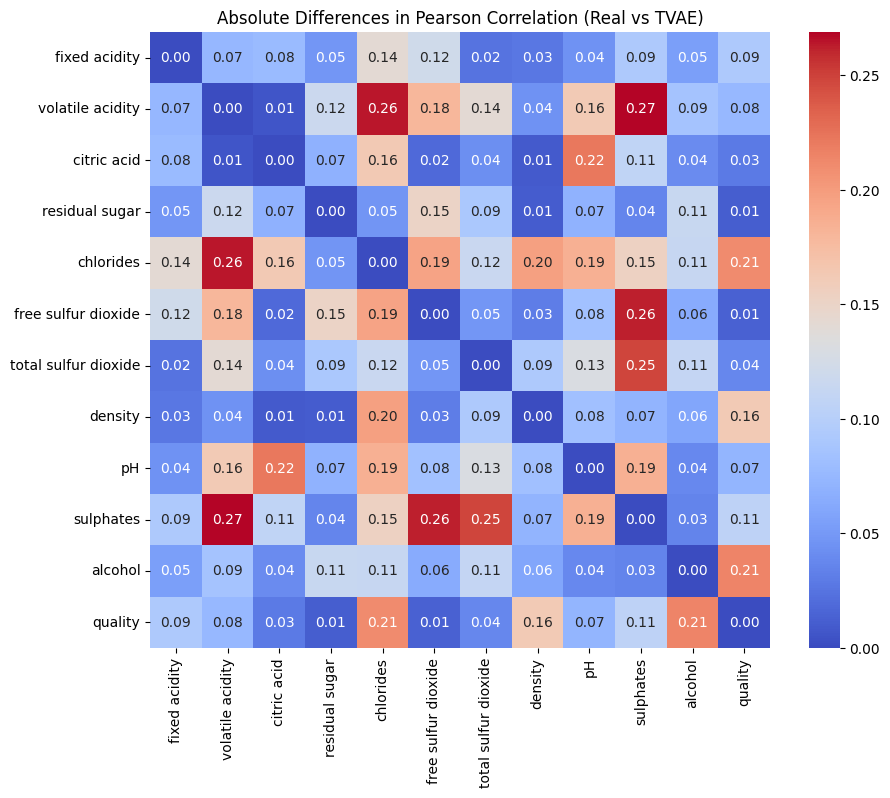

In [72]:
diff_tvae = (real_pearson - tvae_pearson).abs()
plt.figure(figsize=(10, 8))
sns.heatmap(diff_tvae, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Absolute Differences in Pearson Correlation (Real vs TVAE)")
plt.show()

In [58]:
# Compute absolute differences (you already have diff_df)
abs_diff = diff_tvae.abs()

# Mean absolute difference (off-diagonal)
vals = abs_diff.values[np.triu_indices_from(abs_diff, k=1)]
print("Mean absolute Pearson diff:", round(vals.mean(), 3))

# Find top 3 biggest drifts
pairs = []
for i, j in zip(*np.triu_indices_from(abs_diff, k=1)):
    pairs.append((abs_diff.iloc[i, j], diff_tvae.columns[i], diff_tvae.columns[j]))
top3 = sorted(pairs, reverse=True)[:3]
print("Top 3 biggest correlation shifts:")
for diff, f1, f2 in top3:
    print(f"  {f1!r} vs {f2!r}: Δ = {diff:.2f}")

Mean absolute Pearson diff: 0.113
Top 3 biggest correlation shifts:
  'density' vs 'quality': Δ = 0.30
  'chlorides' vs 'quality': Δ = 0.28
  'free sulfur dioxide' vs 'sulphates': Δ = 0.28


In [59]:
# Check exact duplicates between real and synthetic data
duplicates = synthetic_data.merge(data.drop_duplicates(), how='inner')
print(f"Number of exact duplicates: {len(duplicates)}")


Number of exact duplicates: 0


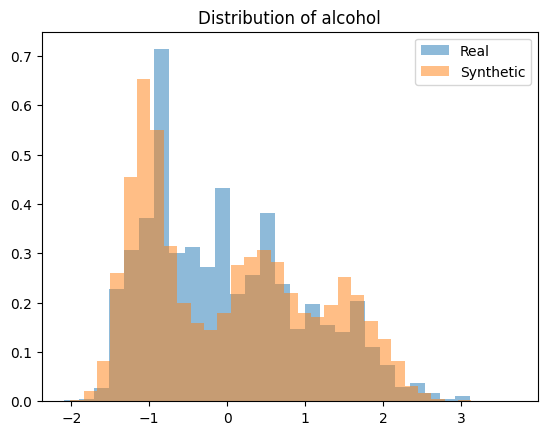

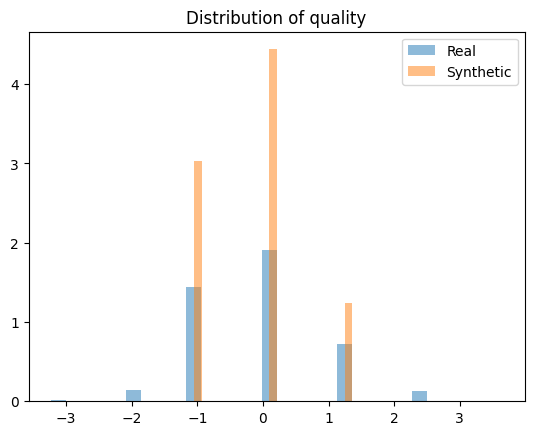

In [60]:
import matplotlib.pyplot as plt

cols_to_check = ['alcohol', 'quality']  # replace with real column names
for col in cols_to_check:
    plt.hist(data[col], bins=30, alpha=0.5, label='Real', density=True)
    plt.hist(synthetic_data[col], bins=30, alpha=0.5, label='Synthetic', density=True)
    plt.title(f'Distribution of {col}')
    plt.legend()
    plt.show()


In [61]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

# Label your data
real_labeled = data.copy()
real_labeled["label"] = 1

synth_labeled = synthetic_data.copy()
synth_labeled["label"] = 0

# Combine and shuffle
combined = pd.concat([real_labeled, synth_labeled], ignore_index=True)

X = combined.drop(columns=["label"])
y = combined["label"]

# One-hot encode all categorical columns
X = pd.get_dummies(X)

# Fill any NaNs
X = X.fillna(0)

# Split and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Discriminator Accuracy: {acc:.2f}")



Discriminator Accuracy: 0.99


In [63]:
for col in data.columns:
    print(col)
    print("  real:", data[col].min(), data[col].max(), data[col].std())
    print("  synth:", synthetic_data[col].min(), synthetic_data[col].max(), synthetic_data[col].std())


fixed acidity
  real: -2.6345888571881577 6.699425498517088 1.0000769674813532
  synth: -2.0540074066514142 4.464725403811912 0.7850605296788793
volatile acidity
  real: -1.8176805404422256 5.771085539947468 1.0000769674813532
  synth: -1.7114830595090642 2.818179417554912 0.9111472342972644
citric acid
  real: -2.1928325189113975 9.23128086996183 1.0000769674813532
  synth: -2.1928325189113975 3.8665231438147565 0.9800337029291106
residual sugar
  real: -1.687053099802906 3.7838665329754337 1.0000769674813532
  synth: -1.5877409671316007 2.1904548532322323 1.0631156281722245
chlorides
  real: -1.46377960866215 13.734706099791728 1.0000769674813532
  synth: -1.4063715805976098 2.4088401657050738 0.6075782566098609
free sulfur dioxide
  real: -3.927293335935015 3.6657221013410553 1.0000769674813532
  synth: -3.492699419942028 1.903290045463935 1.1307782838432139
total sulfur dioxide
  real: -3.765669344759832 2.161136172282822 1.0000769674813532
  synth: -3.765669344759832 1.78139829014

TypeError: could not convert string to float: 'red'

In [73]:
from sdv.evaluation.single_table import evaluate_quality
score = evaluate_quality(data, synthetic_data, metadata)
print(score)


Generating report ...

(1/2) Evaluating Column Shapes: |█████████████| 13/13 [00:00<00:00, 318.57it/s]|
Column Shapes Score: 89.29%

(2/2) Evaluating Column Pair Trends: |████████| 78/78 [00:00<00:00, 468.19it/s]|
Column Pair Trends Score: 89.51%

Overall Score (Average): 89.4%

